In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
from icecream import ic

In [28]:
class Kuramoto:
    def __init__(self, coupling, dt, T, n_nodes):
        self.dt = dt
        self.T = T
        self.coupling = coupling
        self.n_nodes = n_nodes
        self.natfreqs = np.random.normal(size=self.n_nodes)

    def derivative(self, angles_vec, t, adj_mat, k):
        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        interactions = adj_mat * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
        dxdt = self.natfreqs + k * interactions.sum(
            axis=0
        )  # sum over incoming interactions
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        n_interactions = (adj_mat != 0).sum(axis=0)  # number of incoming interactions
        k = (
            self.coupling / n_interactions
        )  # normalize coupling by number of interactions
        t = np.linspace(0, self.T, int(self.T / self.dt))
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat, k))
        return timeseries.T

    def run(self, adj_mat=None, angles_vec=None):
        angles_vec = 2 * np.pi * np.random.random(size=self.n_nodes)
        return self.integrate(angles_vec, adj_mat)

    @staticmethod
    def phase_coherence(angles_vec):
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

In [29]:
def plot_phase_coupling(file, save=False):
    df = pd.read_csv(file, header=None)
    file = file.split("/")[-1]
    data_num = file.split("_")[-2]
    fragment_num = file.split("_")[-1].split(".")[0]
    print(
        "Generating plot for data_num: ", data_num, " and fragment_num: ", fragment_num
    )

    A = df.values
    print(A)
    adjMatrix = np.array(A)
    n = len(adjMatrix)

    # Run model with different coupling (K) parameters (0.2, 0.4, 0.6, 0.8)
    coupling_vals = np.linspace(0, 1, 100)
    runs = []
    for coupling in tqdm(coupling_vals):
        model = Kuramoto(coupling=coupling, dt=0.01, T=100, n_nodes=n)
        model.natfreqs = np.random.normal(1, 0.1, size=n)  # reset natural frequencies
        act_mat = model.run(adjMatrix)
        runs.append(act_mat)

    runs_array = np.array(runs)

    mean_phase_coherences = []
    std_phase_coherences = []
    for i, coupling in tqdm(enumerate(coupling_vals)):
        r_values = [model.phase_coherence(vec) for vec in runs_array[i, :, -8000:].T]
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        mean_phase_coherences.append(r_mean)
        std_phase_coherences.append(r_std)

    # Plot mean phase coherence curve
    plt.figure()
    Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs)  # analytical result (from paper)
    plt.vlines(Kc, 0, 1, linestyles="--", color="orange", label="analytical prediction")
    plt.plot(
        coupling_vals, mean_phase_coherences, color="blue", label="Mean Phase Coherence"
    )
    plt.xlabel("Coupling (K)")
    plt.ylabel("Phase Coherence (R)")
    plt.title("Phase Coherence vs Coupling Strength")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("../figures/" + data_num + "_" + fragment_num + "_mean.png")
    else:
        plt.show()

In [30]:

def plot_parameter_fragment(data_num, save=False):
    '''
    For a single time series take few values of coupling and plot order parameter wrt the 14 segments.So it's order parameter vs epileptogenic zone i.e 14 segments.
    The plot will give info of how the oscillators are synchronized throughout different epileptogenic zone at various couplings.
    '''

    data = [ pd.read_csv(f'../data/binary/{data_num}_{i}.csv', header=None) for i in range(14) ]
    data = [df.values for df in data]
    data = np.array(data)
    n_nodes = data[0].shape[0]
    coupling_vals = [0.2, 0.4, 0.6, 0.8]
    order_parameters = []
    
    print(f'Generating plot for data_num: {data_num}')

    for coupling in coupling_vals:
        print(f'Running for coupling: {coupling}')
        model = Kuramoto(coupling=coupling, dt=0.01, T=100, n_nodes=n_nodes)
        model.natfreqs = np.random.normal(1, 0.1, size=n_nodes)  # reset natural frequencies
        order_params = []
        for i in range(14):
            # print(f'Running for segment: {i}')
            act_mat = model.run(data[i])
            r_values = [model.phase_coherence(vec) for vec in act_mat[:, -8000:].T]
            r_mean = np.mean(r_values)
            order_params.append(r_mean)
        order_parameters.append(order_params)

    order_parameters = np.array(order_parameters)
    print(order_parameters.shape)
    
    plt.figure()
    for i, coupling in enumerate(coupling_vals):
        plt.plot(order_parameters[i], label=f'Coupling: {coupling}')
    plt.xlabel('Epileptogenic Zone')
    plt.ylabel('Order Parameter')
    plt.title('Order Parameter (R) vs Epileptogenic Zone for ' + data_num)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
    plt.grid(True)

    if save:
        plt.savefig(f'../figures/{data_num}_order_zone.png')
    else:
        plt.show()

Generating plot for data_num:  111g0L  and fragment_num:  0
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 44.80it/s]
100it [00:12,  8.04it/s]


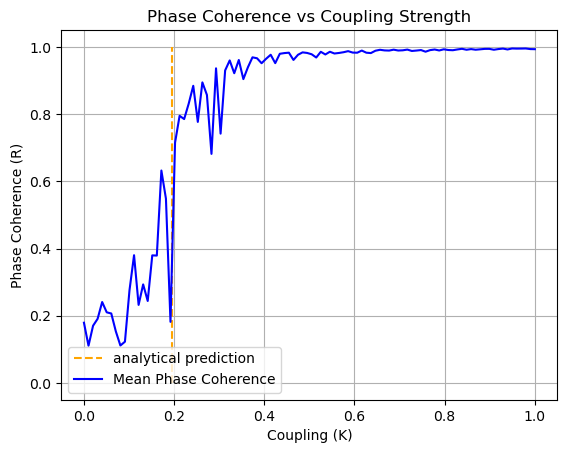

Generating plot for data_num:  111g0L  and fragment_num:  4
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 0 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 0 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 43.66it/s]
100it [00:13,  7.47it/s]


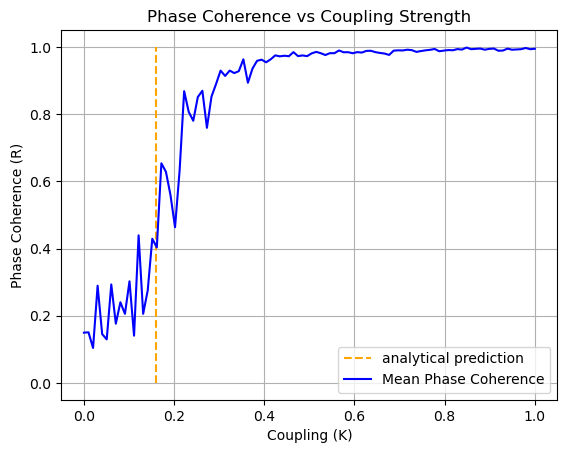

Generating plot for data_num:  111g0L  and fragment_num:  9
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 41.78it/s]
100it [00:14,  7.12it/s]


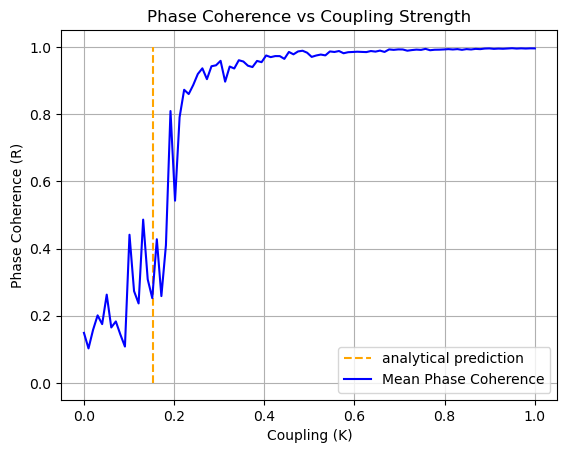

Generating plot for data_num:  111g0L  and fragment_num:  13
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 43.69it/s]
100it [00:13,  7.35it/s]


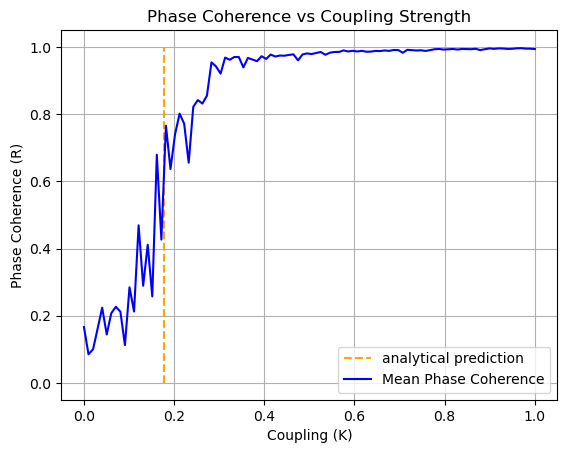

In [31]:
plot_phase_coupling("../data/binary/111g0L_0.csv")
plot_phase_coupling("../data/binary/111g0L_4.csv")
plot_phase_coupling("../data/binary/111g0L_9.csv")
plot_phase_coupling("../data/binary/111g0L_13.csv")

Generating plot for data_num:  112g0L  and fragment_num:  0
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 1 0 1]
 ...
 [0 0 1 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 1 ... 1 1 0]]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 40.82it/s]
100it [00:13,  7.46it/s]


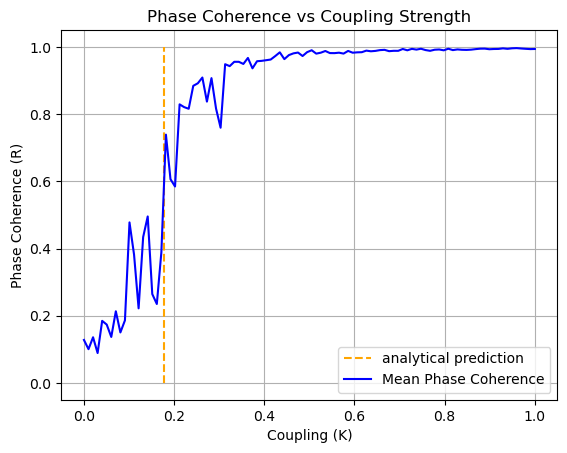

Generating plot for data_num:  112g0L  and fragment_num:  4
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 41.76it/s]
100it [00:15,  6.61it/s]


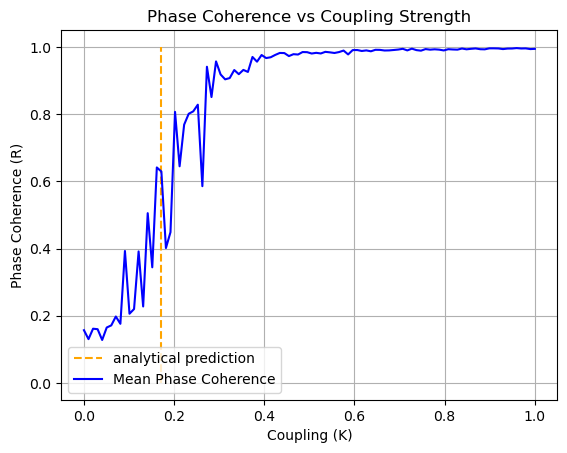

Generating plot for data_num:  112g0L  and fragment_num:  9
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 45.07it/s]
100it [00:13,  7.63it/s]


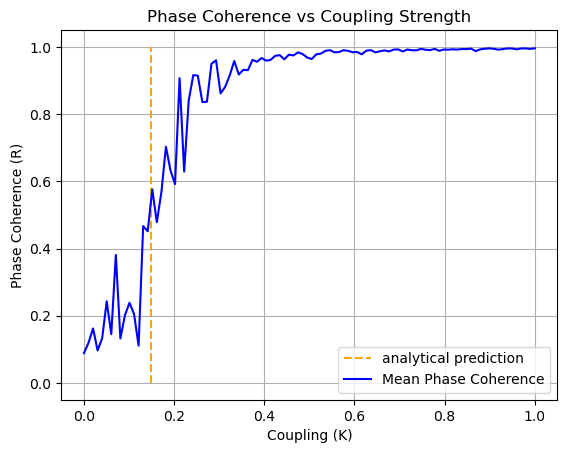

Generating plot for data_num:  112g0L  and fragment_num:  13
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 48.80it/s]
100it [00:13,  7.37it/s]


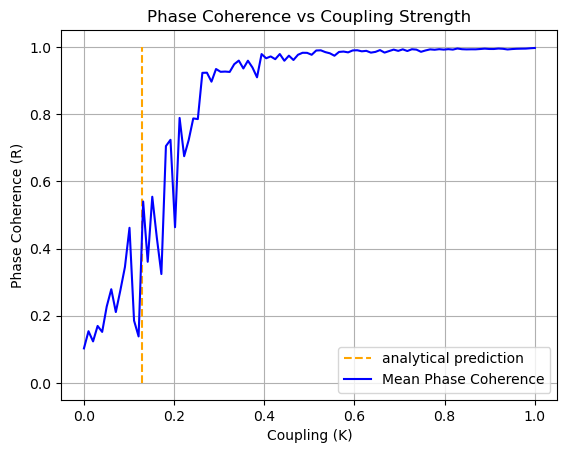

In [32]:
plot_phase_coupling("../data/binary/112g0L_0.csv")
plot_phase_coupling("../data/binary/112g0L_4.csv")
plot_phase_coupling("../data/binary/112g0L_9.csv")
plot_phase_coupling("../data/binary/112g0L_13.csv")

Generating plot for data_num:  113g0R  and fragment_num:  0
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 36.72it/s]
100it [00:14,  6.72it/s]


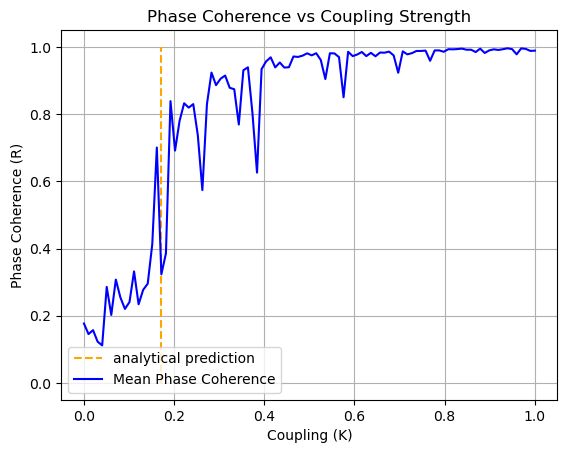

Generating plot for data_num:  113g0R  and fragment_num:  4
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 0]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 0 1 ... 1 1 0]]


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2285092/2043666199.py:20: RuntimeWarning: invalid value encountered in divide
  self.coupling / n_interactions
/home/sovvv/miniconda3/envs/env/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/tmp/ipykernel_2285092/2043666199.py:20: RuntimeWarning: divide by zero encountered in divide
  self.coupling / n_interactions
/tmp/ipykernel_2285092/2043666199.py:12: RuntimeWarning: invalid value encountered in multiply
  dxdt = self.natfreqs + k * interactions.sum(
100%|██████████| 100/100 [00:00<00:00, 1559.69it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220787246706D-05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220769562147D-05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220769811164D-05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220772034088D-05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220795613439D-05   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 


100it [00:14,  7.13it/s]


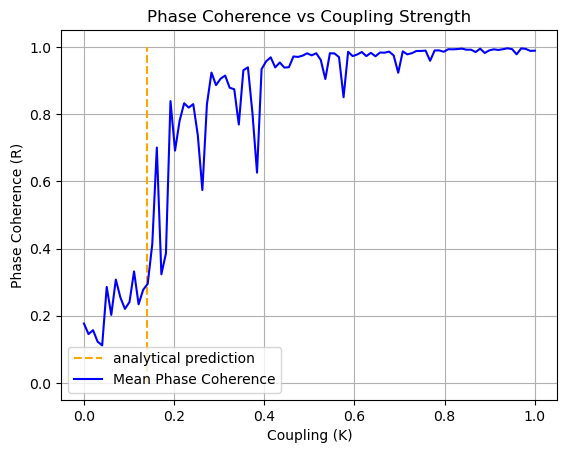

Generating plot for data_num:  113g0R  and fragment_num:  9
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 38.64it/s]
100it [00:13,  7.42it/s]


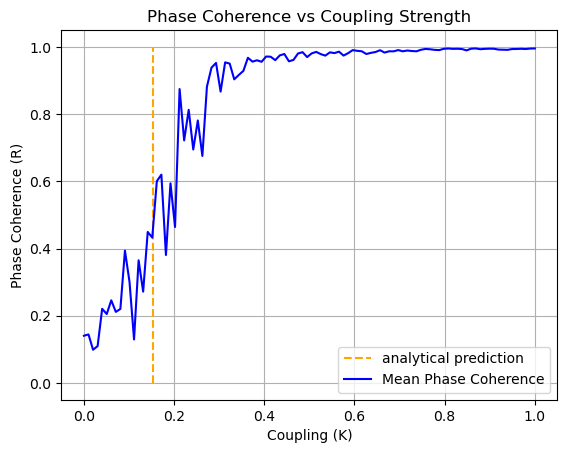

Generating plot for data_num:  113g0R  and fragment_num:  13
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]


100%|██████████| 100/100 [00:02<00:00, 45.73it/s]
100it [00:14,  6.97it/s]


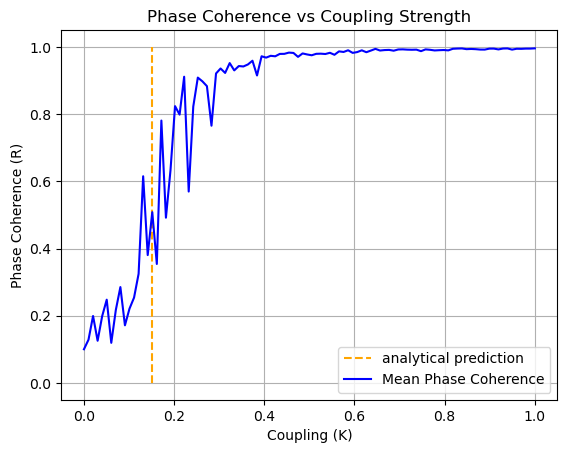

In [33]:
plot_phase_coupling("../data/binary/113g0R_0.csv")
plot_phase_coupling("../data/binary/113g0R_4.csv")
plot_phase_coupling("../data/binary/113g0R_9.csv")
plot_phase_coupling("../data/binary/113g0R_13.csv")

Generating plot for data_num: 111g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


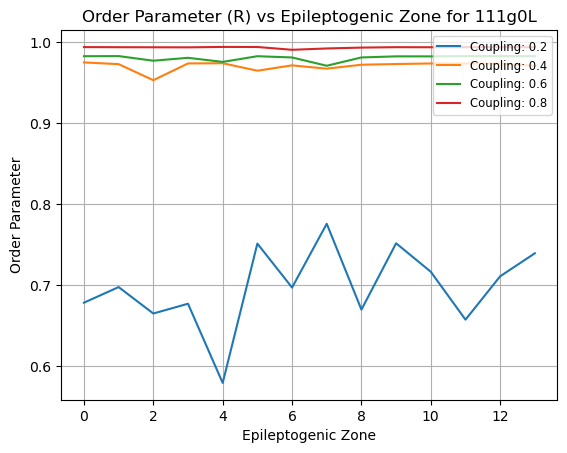

In [34]:
plot_parameter_fragment('111g0L')

Generating plot for data_num: 112g0L
Running for coupling: 0.2
Running for coupling: 0.4
Running for coupling: 0.6
Running for coupling: 0.8
(4, 14)


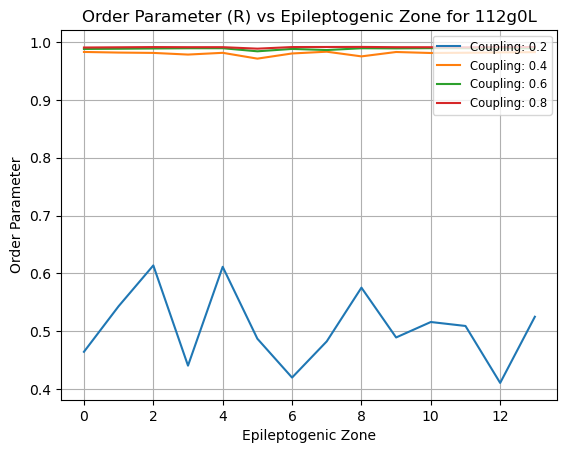

In [35]:
plot_parameter_fragment('112g0L')

Generating plot for data_num: 113g0R
Running for coupling: 0.2


/tmp/ipykernel_2285092/2043666199.py:20: RuntimeWarning: divide by zero encountered in divide
  self.coupling / n_interactions
/tmp/ipykernel_2285092/2043666199.py:12: RuntimeWarning: invalid value encountered in multiply
  dxdt = self.natfreqs + k * interactions.sum(
/home/sovvv/miniconda3/envs/env/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220730490999D-05   r2 =                  NaN
Running for coupling: 0.4
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220794427692D-05   r2 =                  NaN
Running for coupling: 0.6
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220772628483D-05   r2 =                  NaN
Running for coupling: 0.8
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1220753581519D-05   r2 =                  NaN
(4, 14)


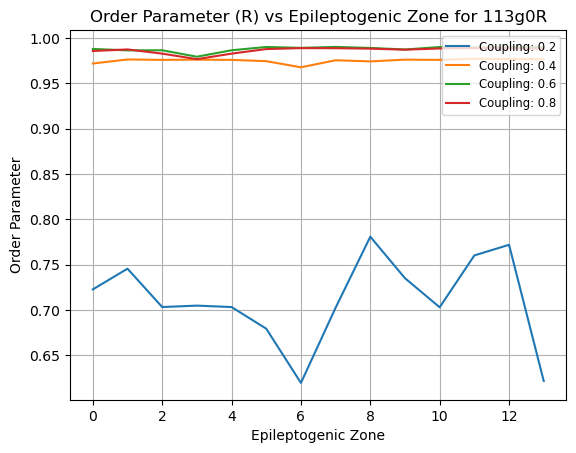

In [36]:
plot_parameter_fragment('113g0R')